In [4]:
import numpy as np 
import pandas as pd 


from google.colab import drive
drive.mount("/content/drive", force_remount=True)

df = pd.read_csv("/content/drive/My Drive/DS340W/phishing_urls.csv")



Mounted at /content/drive


# Import the libraries

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from tensorflow import keras
from keras.models import Sequential
from keras import Input
from keras.layers import Dense

# Read the data

In [6]:
print(df.shape)
df.head()

(549346, 2)


,URL,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad
3,mail.printakid.com/www.online.americanexpress....,bad
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad


In [7]:
df.Label.value_counts()

good    392924
bad     156422
Name: Label, dtype: int64

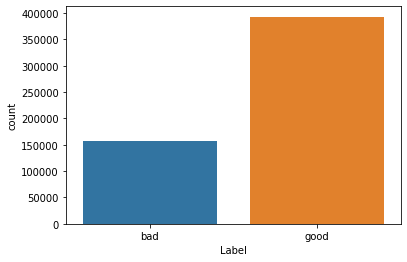

In [8]:
sns.countplot(data=df, x="Label")
plt.show()

# Shuffle the data

In [9]:
df_shuffled = shuffle(df, random_state=42)

# Choose 5000 samples

In [10]:
data_size = 5000

In [11]:
df_used = df_shuffled[:data_size].copy()

# Make sure the distribution is the same after taking the sample

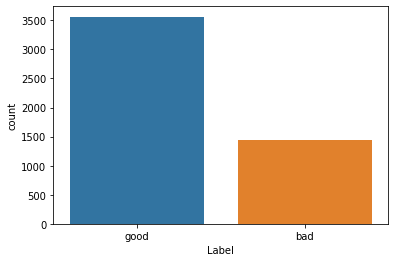

In [12]:
sns.countplot(data=df_used, x="Label")
plt.show()

In [13]:
df_used.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 452638 to 170545
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   URL     5000 non-null   object
 1   Label   5000 non-null   object
dtypes: object(2)
memory usage: 246.2+ KB


# Replace the labels

In [14]:
df_used.replace({'good':0, 'bad':1}, inplace=True)

In [15]:
df_used.Label.value_counts()

0    3562
1    1438
Name: Label, dtype: int64

# Divide the data into features and labels

In [16]:
X = df_used[['URL']].copy()
y = df_used.Label.copy()

# Initialize the tokenizer, stemmer, and Vectorizer

In [17]:
tokenizer = RegexpTokenizer(r'[A-Za-z]+')
stemmer = SnowballStemmer("english")
cv = CountVectorizer()

# Prepare the data

In [18]:
def prepare_data(X) :
    X['text_tokenized'] = X.URL.map(lambda t: tokenizer.tokenize(t))
    X['text_stemmed'] = X.text_tokenized.map(lambda t: [stemmer.stem(word) for word in t])
    X['text_sent'] = X.text_stemmed.map(lambda t: ' '.join(t))
    features = cv.fit_transform(X.text_sent)
    return X, features

In [19]:
X, features = prepare_data(X)

# Import and intitialize the models

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [21]:
logreg = LogisticRegression()
knn = KNeighborsClassifier()
dtree = DecisionTreeClassifier()
rfc = RandomForestClassifier()
svc = SVC()

# Train and test the models using different training percentages

In [22]:
def train_test_model(model, X, y, training_percentage) :
    trainX, testX, trainY, testY = train_test_split(X, y, test_size=1-training_percentage, stratify=y, random_state=42)
    model.fit(trainX, trainY)
    predY = model.predict(testX)
    accuracy = accuracy_score(testY, predY)
    precision = precision_score(testY, predY, pos_label=1)
    recall = recall_score(testY, predY, pos_label=1)
    return accuracy, precision, recall  

In [23]:
training_sizes = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [24]:
def model_results(model) :
    results = []
    for p in training_sizes :
        results.append(train_test_model(model, features, y, p))
    return pd.DataFrame(results, columns=['Accuracy', 'Precision', 'Recall'])

In [25]:
logreg_results = model_results(logreg)
knn_results = model_results(knn)
dtree_results = model_results(dtree)
rfc_results = model_results(rfc)
svc_results = model_results(svc)

In [26]:
models = ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'SVM']
model_results = [logreg_results, knn_results, dtree_results, rfc_results, svc_results]

In [27]:
accuracies = []
precisions = []
recalls = []
for model in model_results :
    accuracies.append(model.Accuracy.values)
    precisions.append(model.Precision.values)
    recalls.append(model.Recall.values)

In [28]:
accuracies = pd.DataFrame(np.transpose(accuracies), columns=models, index=training_sizes*100)
precisions = pd.DataFrame(np.transpose(precisions), columns=models, index=training_sizes*100)
recalls = pd.DataFrame(np.transpose(recalls), columns=models, index=training_sizes*100)

In [29]:
accuracies

,Logistic Regression,KNN,Decision Tree,Random Forest,SVM
10.0,0.830667,0.739778,0.819111,0.845556,0.783111
20.0,0.863500,0.727750,0.843000,0.871500,0.832750
30.0,0.881429,0.726286,0.856571,0.879714,0.847143
40.0,0.885667,0.736000,0.858000,0.886000,0.856333
50.0,0.892400,0.750800,0.866000,0.893200,0.864400
60.0,0.900500,0.750000,0.863500,0.898000,0.872500
70.0,0.909394,0.765490,0.874750,0.904064,0.880746
80.0,0.902000,0.742000,0.876000,0.900000,0.878000
90.0,0.896000,0.738000,0.878000,0.886000,0.872000


In [30]:
precisions

,Logistic Regression,KNN,Decision Tree,Random Forest,SVM
10.0,0.915625,0.557423,0.790557,0.866585,0.954286
20.0,0.914835,0.526091,0.813702,0.911917,0.925664
30.0,0.920455,0.521548,0.838926,0.925872,0.918440
40.0,0.901235,0.538883,0.811698,0.930579,0.892727
50.0,0.894737,0.564000,0.825424,0.939689,0.889344
60.0,0.917778,0.560976,0.821277,0.940618,0.937158
70.0,0.930233,0.590498,0.824468,0.936364,0.937716
80.0,0.916667,0.546296,0.815385,0.927273,0.932292
90.0,0.933962,0.538922,0.860870,0.930693,0.925532


In [31]:
recalls

,Logistic Regression,KNN,Decision Tree,Random Forest,SVM
10.0,0.452859,0.461360,0.504637,0.547141,0.258114
20.0,0.579130,0.534783,0.588696,0.612174,0.454783
30.0,0.643496,0.588878,0.620655,0.632572,0.514399
40.0,0.676709,0.570104,0.659328,0.652375,0.568946
50.0,0.709318,0.588317,0.677330,0.671766,0.603616
60.0,0.718261,0.600000,0.671304,0.688696,0.596522
70.0,0.740741,0.604167,0.717593,0.715278,0.627315
80.0,0.725694,0.614583,0.736111,0.708333,0.621528
90.0,0.687500,0.625000,0.687500,0.652778,0.604167


# Plot the accuracy, precision, and recall of the 5 models

Text(0, 0.5, 'Accuracy')

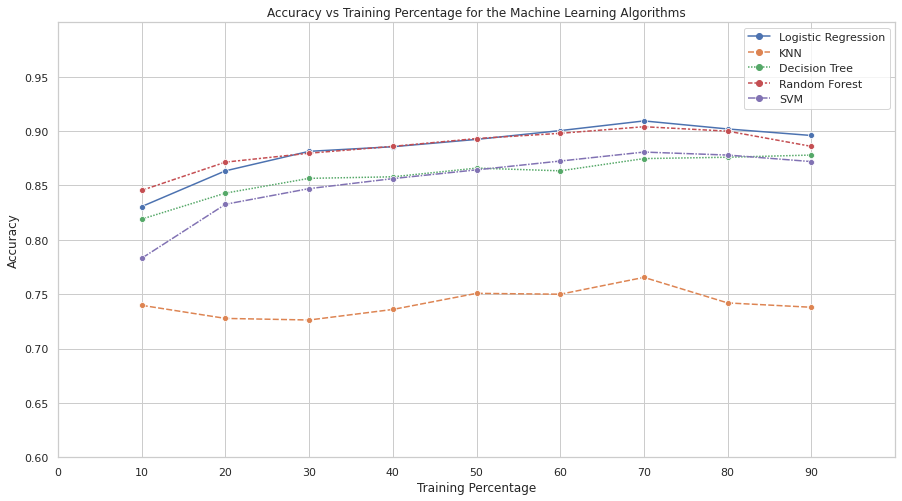

In [32]:
sns.set(rc={'figure.figsize':(15,8)})
sns.set_style('whitegrid')
g = sns.lineplot(data = accuracies, markers= ['o', 'o', 'o', 'o', 'o'])
g.set(xlim = (0,100), ylim = (0.6,1), xticks = np.arange(0, 100, 10), yticks = np.arange(0.6, 1, 0.05))
g.set_title("Accuracy vs Training Percentage for the Machine Learning Algorithms")
g.set_xlabel("Training Percentage")
g.set_ylabel("Accuracy")

Text(0, 0.5, 'Precision')

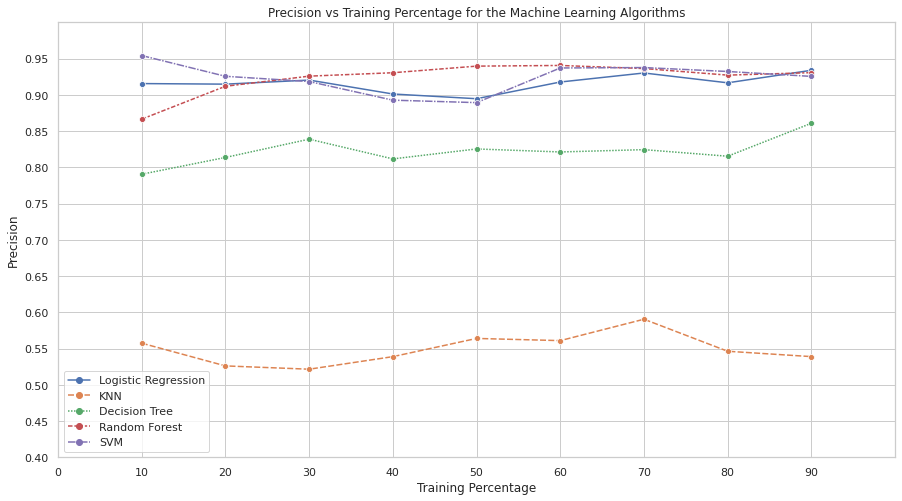

In [33]:
sns.set(rc={'figure.figsize':(15,8)})
sns.set_style('whitegrid')
g = sns.lineplot(data = precisions, markers= ['o', 'o', 'o', 'o', 'o'])
g.set(xlim = (0,100), ylim = (0.4,1), xticks = np.arange(0, 100, 10), yticks = np.arange(0.4, 1, 0.05))
g.set_title("Precision vs Training Percentage for the Machine Learning Algorithms")
g.set_xlabel("Training Percentage")
g.set_ylabel("Precision")

Text(0, 0.5, 'Recall')

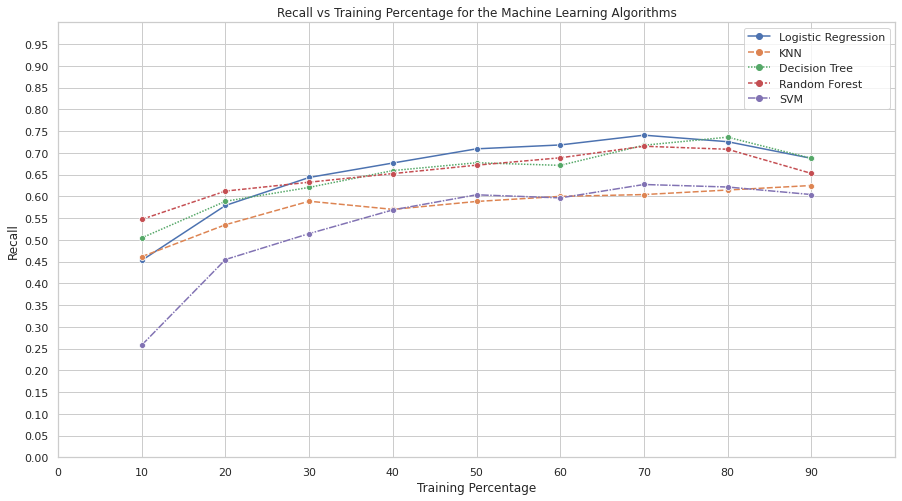

In [34]:
sns.set(rc={'figure.figsize':(15,8)})
sns.set_style('whitegrid')
g = sns.lineplot(data = recalls, markers= ['o', 'o', 'o', 'o', 'o'])
g.set(xlim = (0,100), ylim = (0,1), xticks = np.arange(0, 100, 10), yticks = np.arange(0, 1, 0.05))
g.set_title("Recall vs Training Percentage for the Machine Learning Algorithms")
g.set_xlabel("Training Percentage")
g.set_ylabel("Recall")

In [35]:
phishingPhone = pd.read_csv("/content/drive/My Drive/DS340W/phishingPhone.csv")

In [36]:
X=np.array(phishingPhone[["phoneNum"]])
Y=np.array(phishingPhone["Label"])

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.2)

In [38]:
model=LogisticRegression(C=0.01,solver='liblinear')
model.fit(x_train,y_train)
model

LogisticRegression(C=0.01, solver='liblinear')